In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
original_data = pd.read_csv('GOOG.csv')

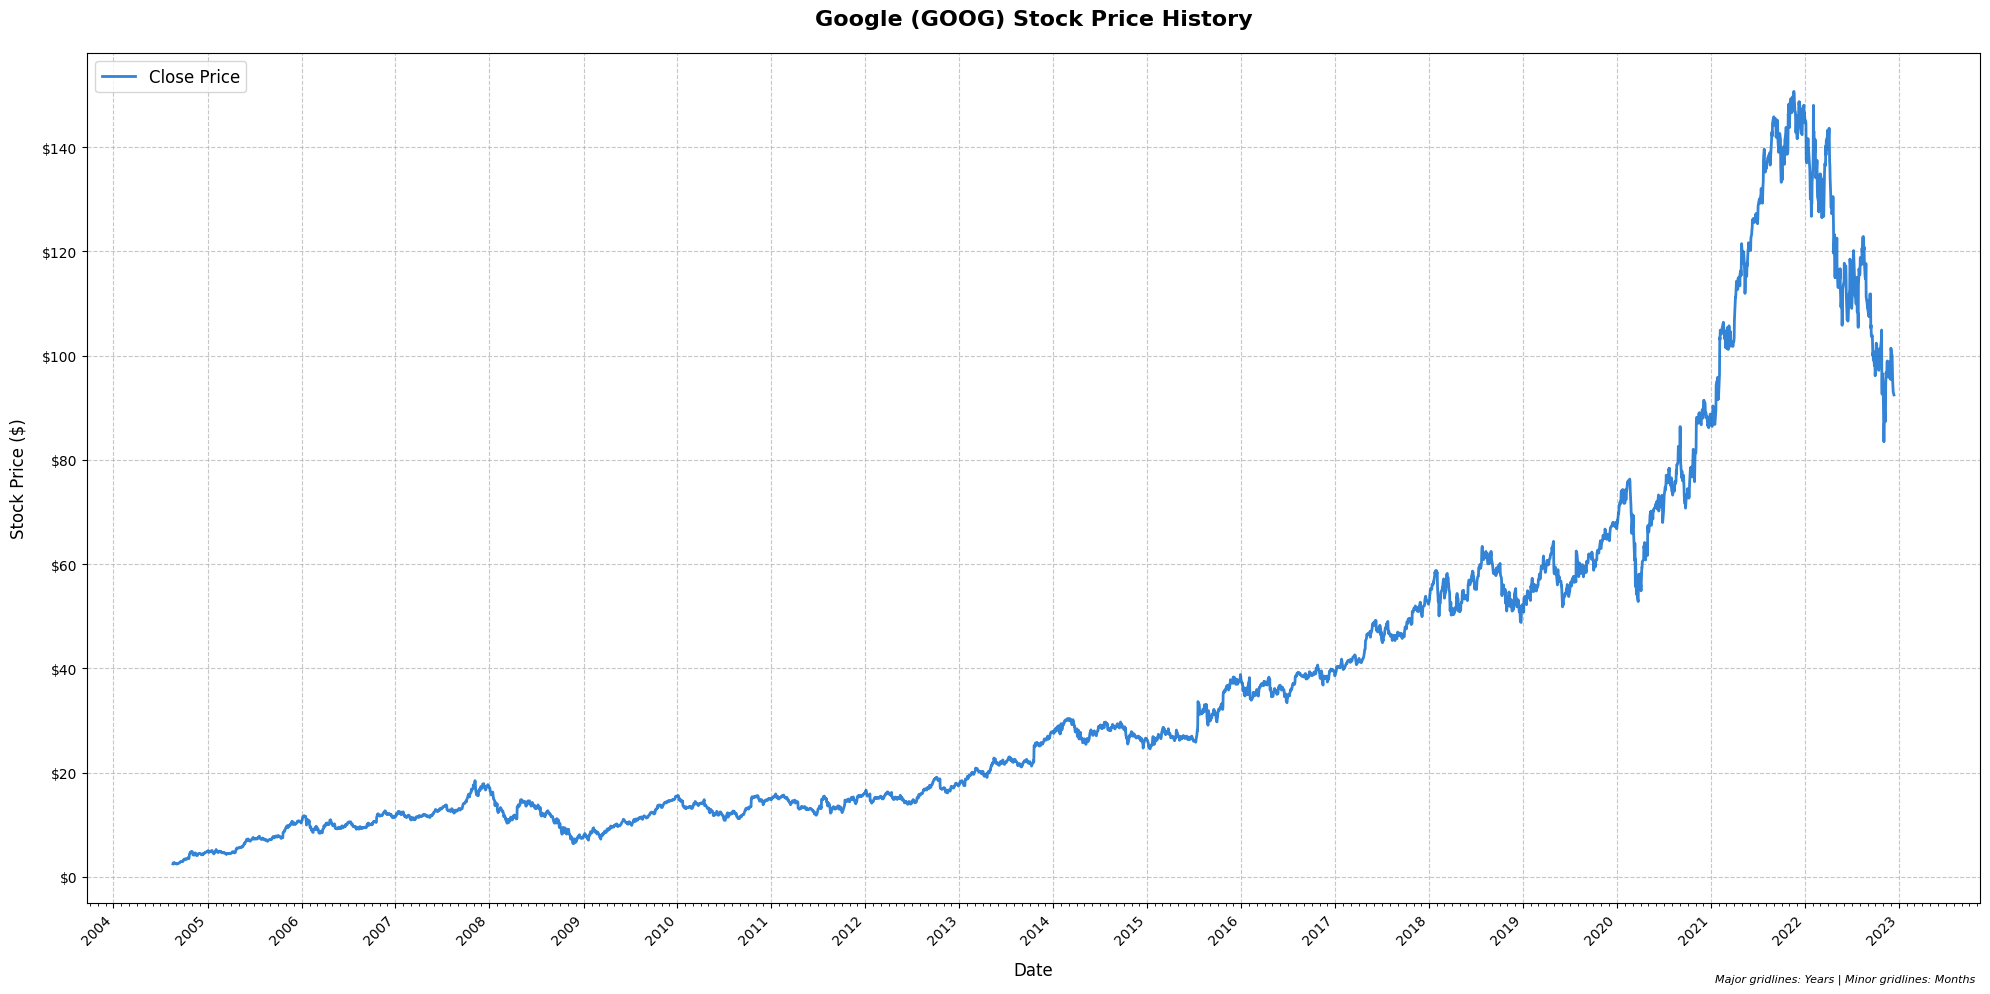

In [15]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

plt.figure(figsize=(20, 10))
plt.plot(original_data['Date'],
         original_data['Close'],
         label='Close Price',
         color='#0066cc',
         linewidth=2,
         alpha=0.8)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Google (GOOG) Stock Price History',
         fontsize=16,
         pad=20,
         fontweight='bold')
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Stock Price ($)', fontsize=12, labelpad=10)

plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

plt.gca().xaxis.set_minor_locator(MonthLocator())
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.legend(fontsize=12, loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.figtext(0.99, 0.01, 'Major gridlines: Years | Minor gridlines: Months',
            ha='right', va='bottom',
            fontsize=8,
            style='italic')
plt.tight_layout()

plt.show()

In [9]:
print("First 5 rows of the dataset:")
print(original_data.head())

print("\nDataset Info:")
print(original_data.info())

print("\nStatistical Summary:")
print(original_data.describe())

print("\nNull Values in Each Column:")
print(original_data.isnull().sum())

First 5 rows of the dataset:
        Date       Low      Open     Volume      High     Close  \
0 2004-08-19  2.390042  2.490664  897427216  2.591785  2.499133   
1 2004-08-20  2.503118  2.515820  458857488  2.716817  2.697639   
2 2004-08-23  2.716070  2.758411  366857939  2.826406  2.724787   
3 2004-08-24  2.579581  2.770615  306396159  2.779581  2.611960   
4 2004-08-25  2.587302  2.614201  184645512  2.689918  2.640104   

   Adjusted Close  
0        2.499133  
1        2.697639  
2        2.724787  
3        2.611960  
4        2.640104  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            4612 non-null   datetime64[ns]
 1   Low             4612 non-null   float64       
 2   Open            4612 non-null   float64       
 3   Volume          4612 non-null   int64         
 4   High      

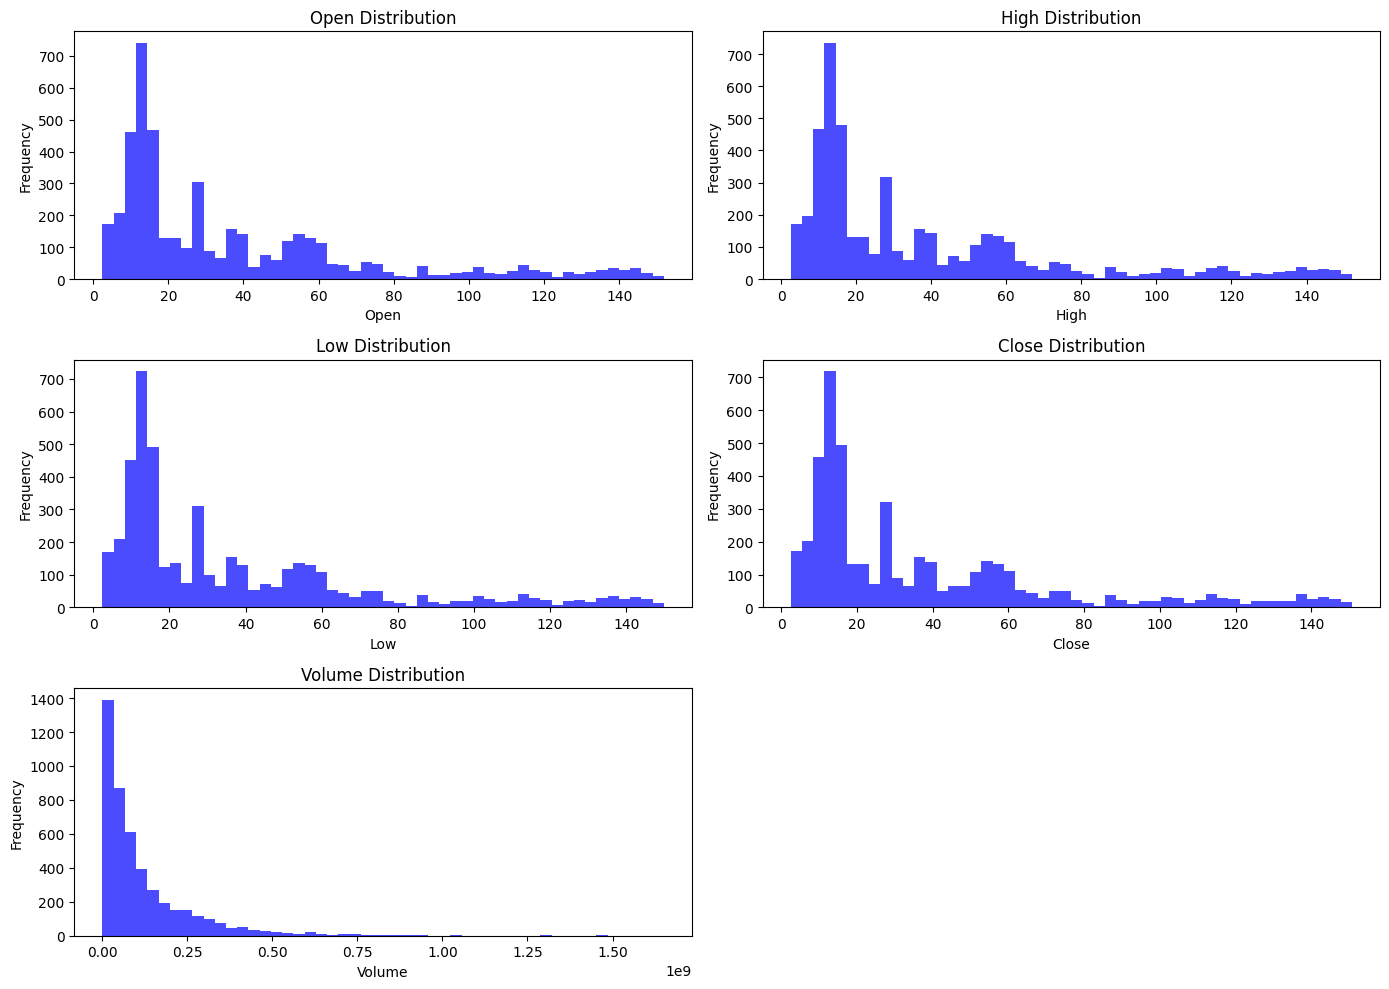

In [10]:
plt.figure(figsize=(14, 10))
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(3, 2, i)
    plt.hist(original_data[column], bins=50, color='blue', alpha=0.7)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [11]:
original_data['Date'] = pd.to_datetime(original_data['Date'])

original_data.sort_values('Date', inplace=True)

dates = original_data['Date'].values

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = original_data[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [12]:

n = len(scaled_data)
test_size = int(n * 0.2)
temp_size = n - test_size
val_size = int(temp_size * 0.2)

train_size = temp_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+val_size]
test_data = scaled_data[train_size+val_size:]

train_dates = dates[:train_size]
val_dates = dates[train_size:train_size+val_size]
test_dates = dates[train_size+val_size:]


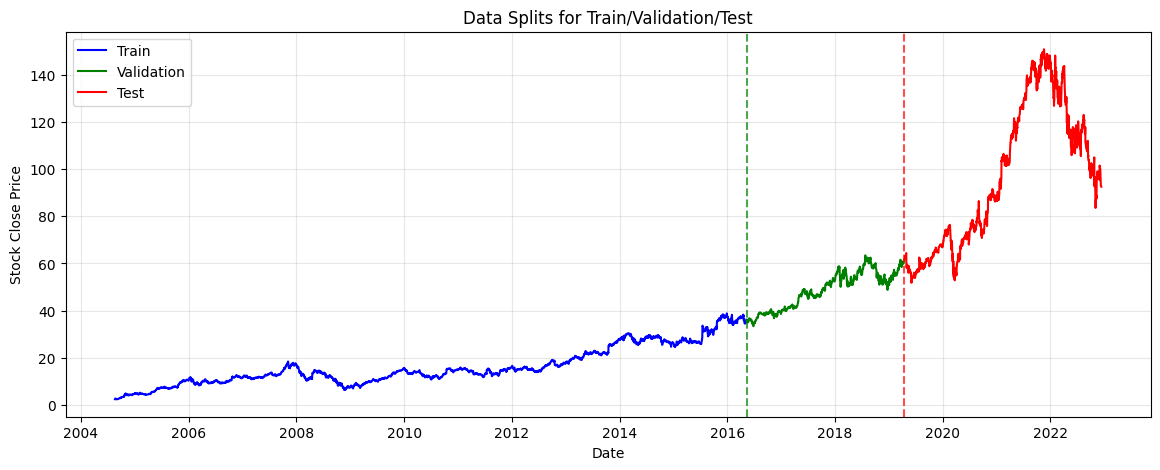

In [13]:
plt.figure(figsize=(14, 5))

actual_closes = original_data['Close'].values

plt.plot(train_dates, actual_closes[:train_size], label='Train', color='blue')
plt.plot(val_dates, actual_closes[train_size:train_size+val_size], label='Validation', color='green')
plt.plot(test_dates, actual_closes[train_size+val_size:], label='Test', color='red')

plt.axvline(x=val_dates[0], color='green', linestyle='--', alpha=0.7)
plt.axvline(x=test_dates[0], color='red', linestyle='--', alpha=0.7)

plt.title('Data Splits for Train/Validation/Test')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
def create_sequences(data, date_array, N, M):
    X, y, y_dt = [], [], []
    for i in range(N, len(data) - M + 1):
        X.append(data[i-N:i])
        y.append(data[i:i+M, 3])  # Predicting the 'Close' price
        y_dt.append(date_array[i+M-1])  # The date corresponding to the predicted day
    return np.array(X), np.array(y), np.array(y_dt)

N = 30  # Number of past days
M = 1   # Predicting the next day

X_train, y_train, y_train_dates = create_sequences(train_data, train_dates, N, M)
X_val, y_val, y_val_dates = create_sequences(val_data, val_dates, N, M)
X_test, y_test, y_test_dates = create_sequences(test_data, test_dates, N, M)

print("Training sequences:", X_train.shape)
print("Validation sequences:", X_val.shape)
print("Testing sequences:", X_test.shape)

Training sequences: (2922, 30, 5)
Validation sequences: (708, 30, 5)
Testing sequences: (892, 30, 5)


In [6]:
batch_size = 32
epochs = 50
units = 50  # Number of neurons in the RNN layer
input_shape = (X_train.shape[1], X_train.shape[2])

In [65]:
class CustomVanillaRNNCell(layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomVanillaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.W_xh = self.add_weight(shape=(input_dim, self.units),
                                    initializer='glorot_uniform',
                                    trainable=True, name='W_xh')
        self.W_hh = self.add_weight(shape=(self.units, self.units),
                                    initializer='orthogonal',
                                    trainable=True, name='W_hh')
        self.b_h = self.add_weight(shape=(self.units,),
                                   initializer='zeros',
                                   trainable=True, name='b_h')
        super(CustomVanillaRNNCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        h = tf.nn.tanh(tf.matmul(inputs, self.W_xh) + tf.matmul(h_prev, self.W_hh) + self.b_h)
        return h, [h]


In [85]:
def build_vanilla_rnn(input_shape, units):
    model = Sequential()
    # First RNN layer, return sequences to allow stacking
    model.add(layers.RNN(CustomVanillaRNNCell(units), return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    # Second RNN layer
    model.add(layers.RNN(CustomVanillaRNNCell(units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

vanilla_rnn_model = build_vanilla_rnn(input_shape, units)
vanilla_rnn_model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_11 (RNN)                         │ (None, 30, 50)              │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_12 (RNN)                         │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,901 (30.86 KB)

 Trainable params: 7,901 (30.86 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
def build_gru(input_shape, units):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_model = build_gru(input_shape, units)
gru_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                         │ (None, 30, 50)              │           8,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_16 (GRU)                         │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
def build_lstm(input_shape, units):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_model = build_lstm(input_shape, units)
lstm_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

callbacks = [early_stopping, reduce_lr]

In [132]:
history_vanilla = vanilla_rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5864e-04 - val_loss: 2.8700e-04 - learning_rate: 4.0000e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2737e-04 - val_loss: 4.0091e-04 - learning_rate: 4.0000e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1398e-04 - val_loss: 3.3235e-04 - learning_rate: 4.0000e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2402e-04 - val_loss: 3.3617e-04 - learning_rate: 4.0000e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0173e-04 - val_loss: 2.8336e-04 - learning_rate: 4.0000e-05
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5608e-04 - val_loss: 2.6570e-04 - learning_rate: 4.0000e-05
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2147e-04 - val_loss: 2.9896e-04 - learning_rate: 8.0000e-06
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8063e-04 - val_loss: 2.8288e-04 - learning_rate: 8.0000e-06
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━

In [133]:
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0041 - val_loss: 1.0029e-04 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5655e-04 - val_loss: 2.0536e-04 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3516e-04 - val_loss: 8.0403e-05 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1122e-04 - val_loss: 1.7111e-04 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1073e-04 - val_loss: 1.6313e-04 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7673e-05 - val_loss: 5.4871e-05 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4397e-05 - val_loss: 1.1301e-04 - learning_rate: 2.0000e-04
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0099e-05 - val_loss: 7.5938e-05 - learning_rate: 2.0000e-04
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5140e-0

In [134]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 9.1885e-04 - val_loss: 1.0870e-04 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5692e-04 - val_loss: 1.5536e-04 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3757e-04 - val_loss: 1.4154e-04 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0637e-04 - val_loss: 9.1862e-05 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0566e-05 - val_loss: 1.3992e-04 - learning_rate: 0.0010


In [135]:
def inverse_transform(y_scaled):
    y_scaled_extended = np.zeros((y_scaled.shape[0], scaled_data.shape[1]))
    # Place predicted close values in the 'Close' column (index 3)
    y_scaled_extended[:, 3] = y_scaled.flatten()
    y_inversed = scaler.inverse_transform(y_scaled_extended)[:, 3]
    return y_inversed

In [136]:
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2_Score'])

In [137]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_scaled = model.predict(X_test)
    y_pred = inverse_transform(y_pred_scaled)
    y_test_actual = inverse_transform(y_test.reshape(-1,1))

    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    new_row = pd.DataFrame({
        'Model': [model_name],
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2_Score': [r2]
    })

    return y_test_actual, y_pred, new_row


In [138]:
y_test_actual, y_pred_vanilla, new_row_vanilla = evaluate_model(vanilla_rnn_model, X_test, y_test, 'Vanilla RNN')
results = pd.concat([results, new_row_vanilla], ignore_index=True)
print(results)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
         Model         MSE       RMSE        MAE      MAPE  R2_Score
0  Vanilla RNN  841.541569  29.009336  23.147326  0.203524  0.045917


In [139]:
_, y_pred_gru, new_row_gru = evaluate_model(gru_model, X_test, y_test, 'GRU')
results = pd.concat([results, new_row_gru], ignore_index=True)
print(results)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
         Model         MSE       RMSE        MAE      MAPE  R2_Score
0  Vanilla RNN  841.541569  29.009336  23.147326  0.203524  0.045917
1          GRU    8.215512   2.866271   2.101034  0.021520  0.990686


In [140]:
_, y_pred_lstm, new_row_lstm = evaluate_model(lstm_model, X_test, y_test, 'LSTM')
results = pd.concat([results, new_row_lstm], ignore_index=True)
print(results)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
         Model         MSE       RMSE        MAE      MAPE  R2_Score
0  Vanilla RNN  841.541569  29.009336  23.147326  0.203524  0.045917
1          GRU    8.215512   2.866271   2.101034  0.021520  0.990686
2         LSTM   17.243365   4.152513   3.131021  0.032503  0.980451


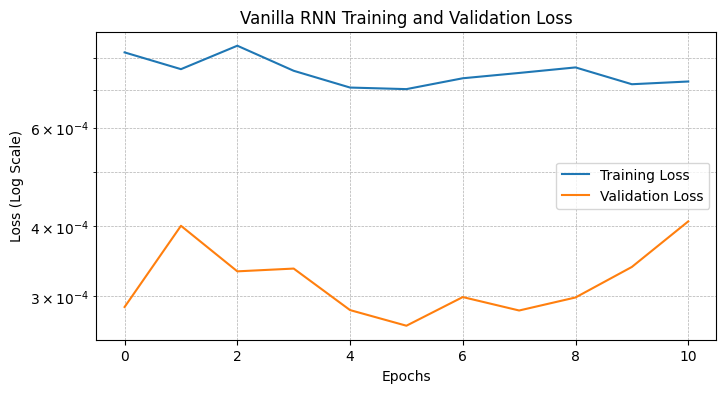

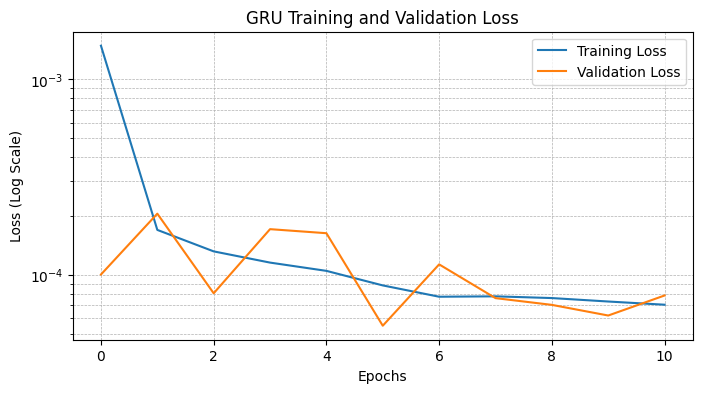

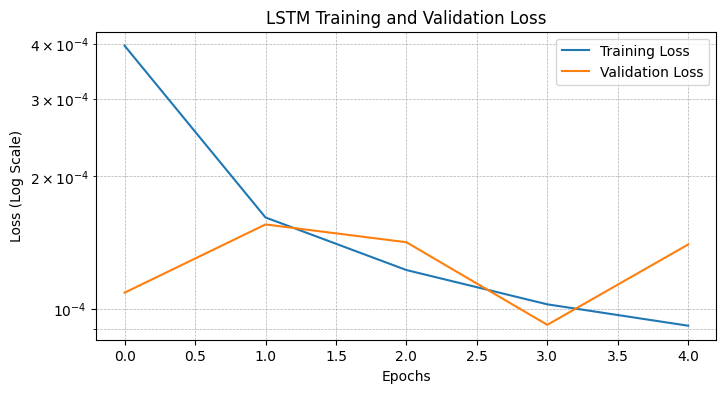

In [141]:
def plot_loss(history, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

plot_loss(history_vanilla, 'Vanilla RNN')
plot_loss(history_gru, 'GRU')
plot_loss(history_lstm, 'LSTM')


In [142]:
def plot_detailed_predictions(dates, y_test_actual, y_pred, model_name):
    plt.figure(figsize=(15, 8))

    plt.plot(dates, y_test_actual, 'r-', label='Actual Price', linewidth=2, alpha=0.7)
    plt.plot(dates, y_pred, 'b--', label=f'Predicted Price ({model_name})', linewidth=2, alpha=0.7)

    n_points = 5
    indices = np.linspace(0, len(dates)-1, n_points, dtype=int)

    for idx in indices:
        plt.annotate(f'${y_test_actual[idx]:.2f}',
                    xy=(dates[idx], y_test_actual[idx]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.1),
                    fontsize=8)

        plt.annotate(f'${y_pred[idx]:.2f}',
                    xy=(dates[idx], y_pred[idx]),
                    xytext=(10, -20), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.1),
                    fontsize=8)

    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred)

    plt.text(0.02, 0.98, f'RMSE: ${rmse:.2f}\nMAE: ${mae:.2f}\nMAPE: {mape*100:.2f}%',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.title(f'Google Stock Price Prediction Details ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt

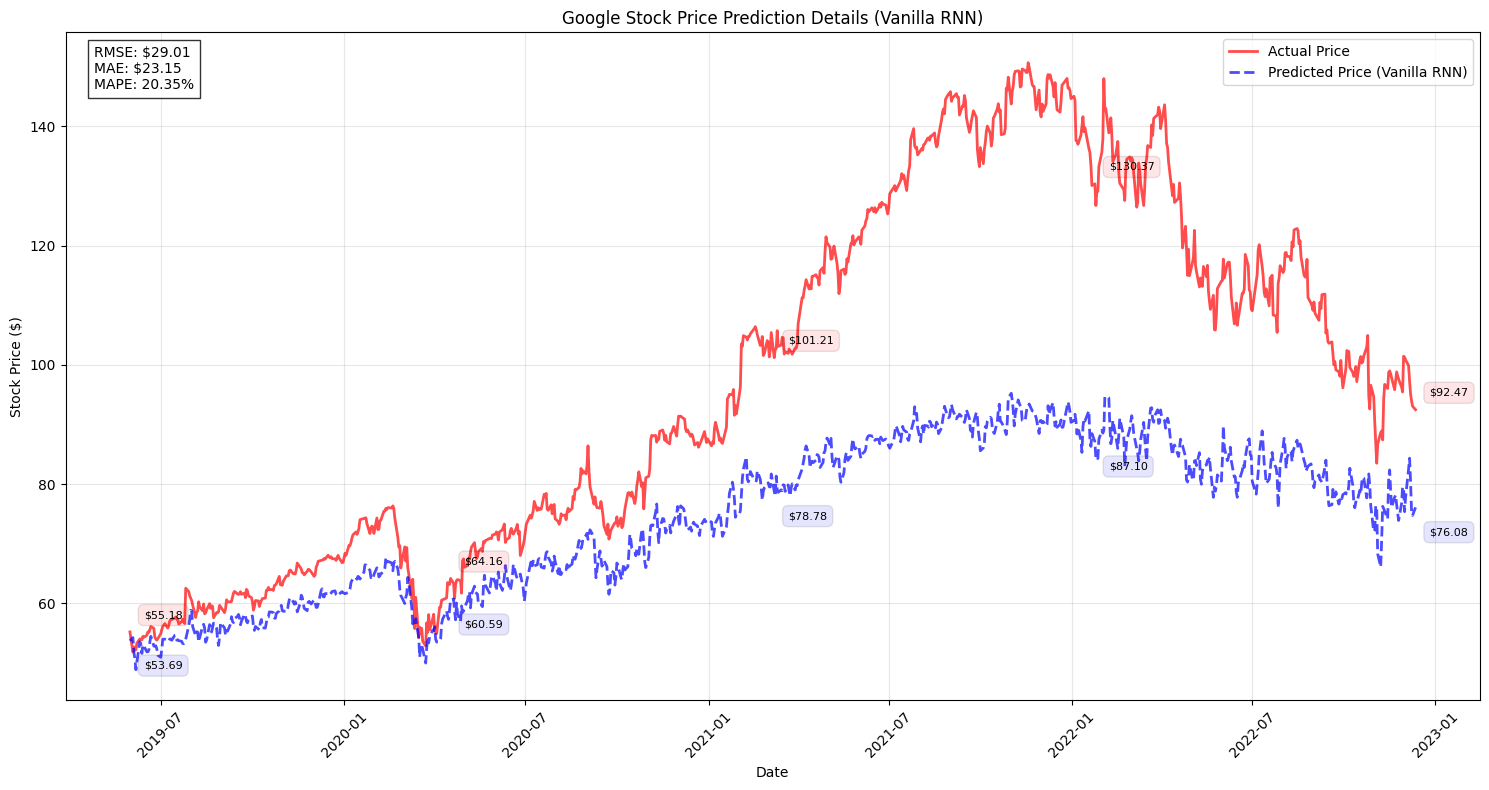

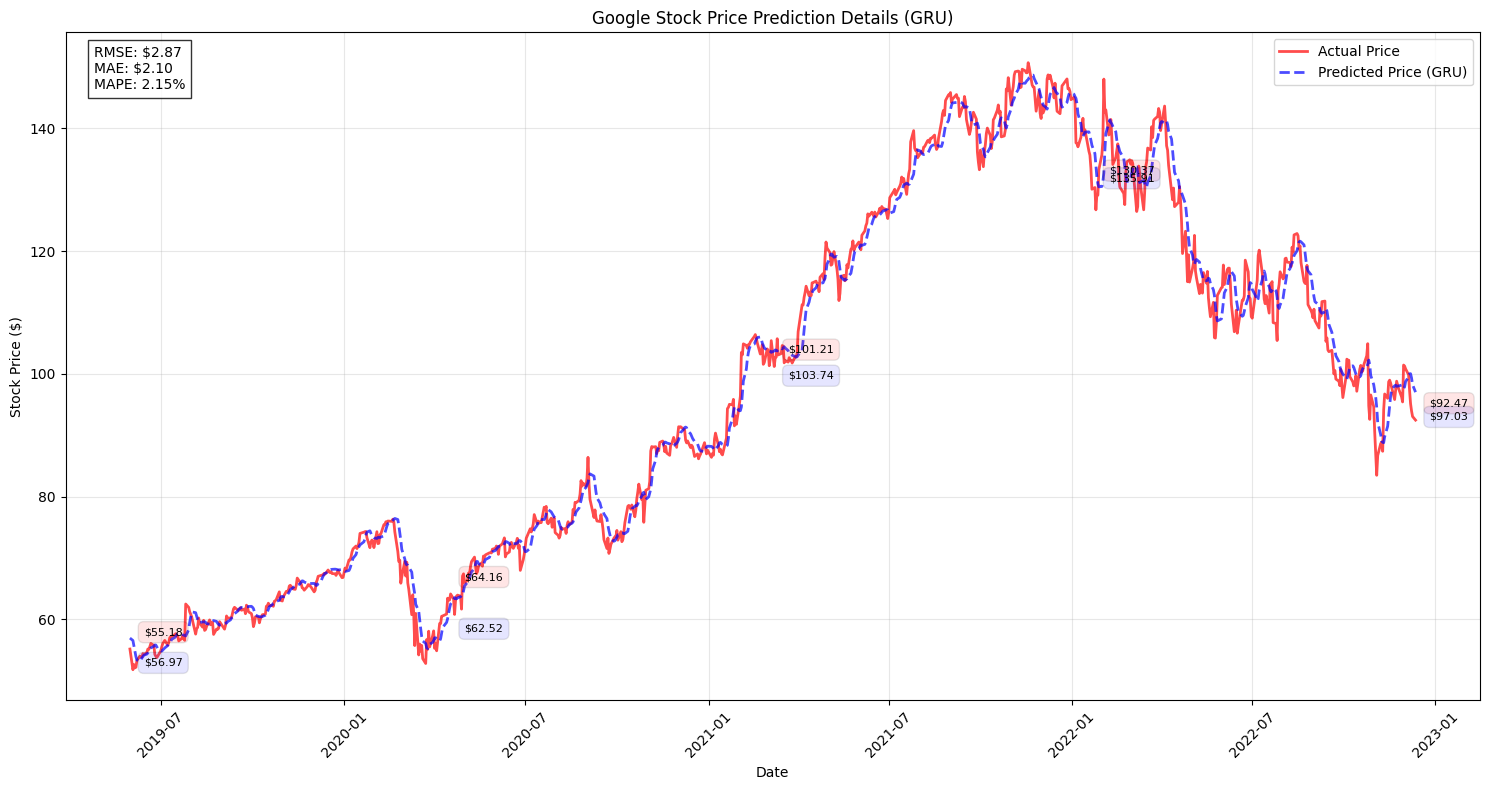

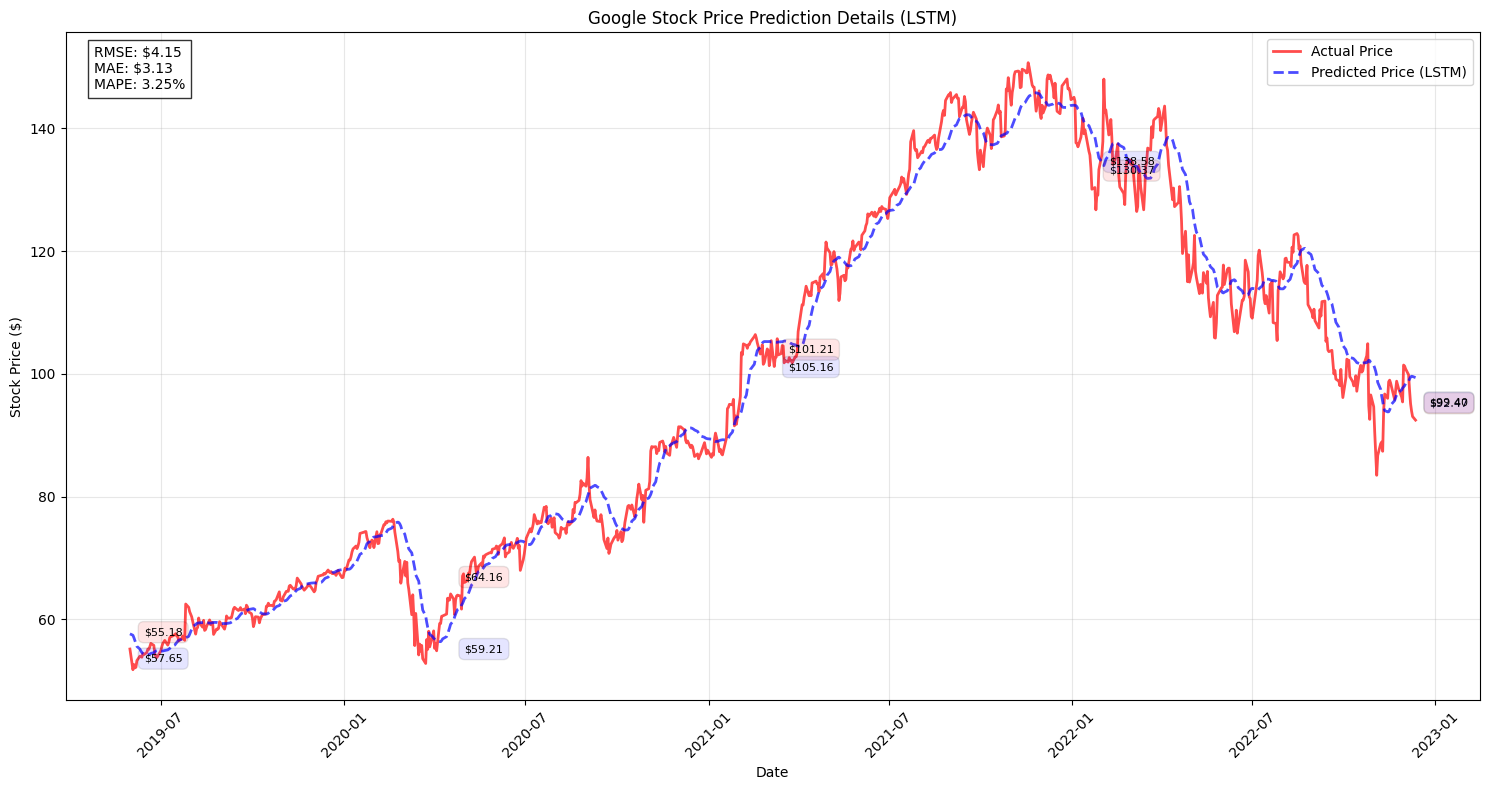

In [143]:
plot_detailed_predictions(y_test_dates, y_test_actual, y_pred_vanilla, 'Vanilla RNN')
plt.show()

plot_detailed_predictions(y_test_dates, y_test_actual, y_pred_gru, 'GRU')
plt.show()

plot_detailed_predictions(y_test_dates, y_test_actual, y_pred_lstm, 'LSTM')
plt.show()

In [144]:
def plot_combined_predictions_detailed(dates, y_test_actual, y_pred_dict):
    plt.figure(figsize=(15, 8))

    plt.plot(dates, y_test_actual, 'r-', label='Actual Price', linewidth=2, alpha=0.7)

    colors = {'Vanilla RNN': 'blue', 'GRU': 'green', 'LSTM': 'orange'}

    for model_name, predictions in y_pred_dict.items():
        plt.plot(dates, predictions, '--',
                color=colors[model_name],
                label=f'{model_name} Predictions',
                linewidth=2,
                alpha=0.7)

    n_points = 3
    indices = np.linspace(0, len(dates)-1, n_points, dtype=int)

    for idx in indices:
        plt.annotate(f'${y_test_actual[idx]:.2f}',
                    xy=(dates[idx], y_test_actual[idx]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.1),
                    fontsize=8)

    plt.title('Google Stock Price Prediction Comparison (All Models)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt

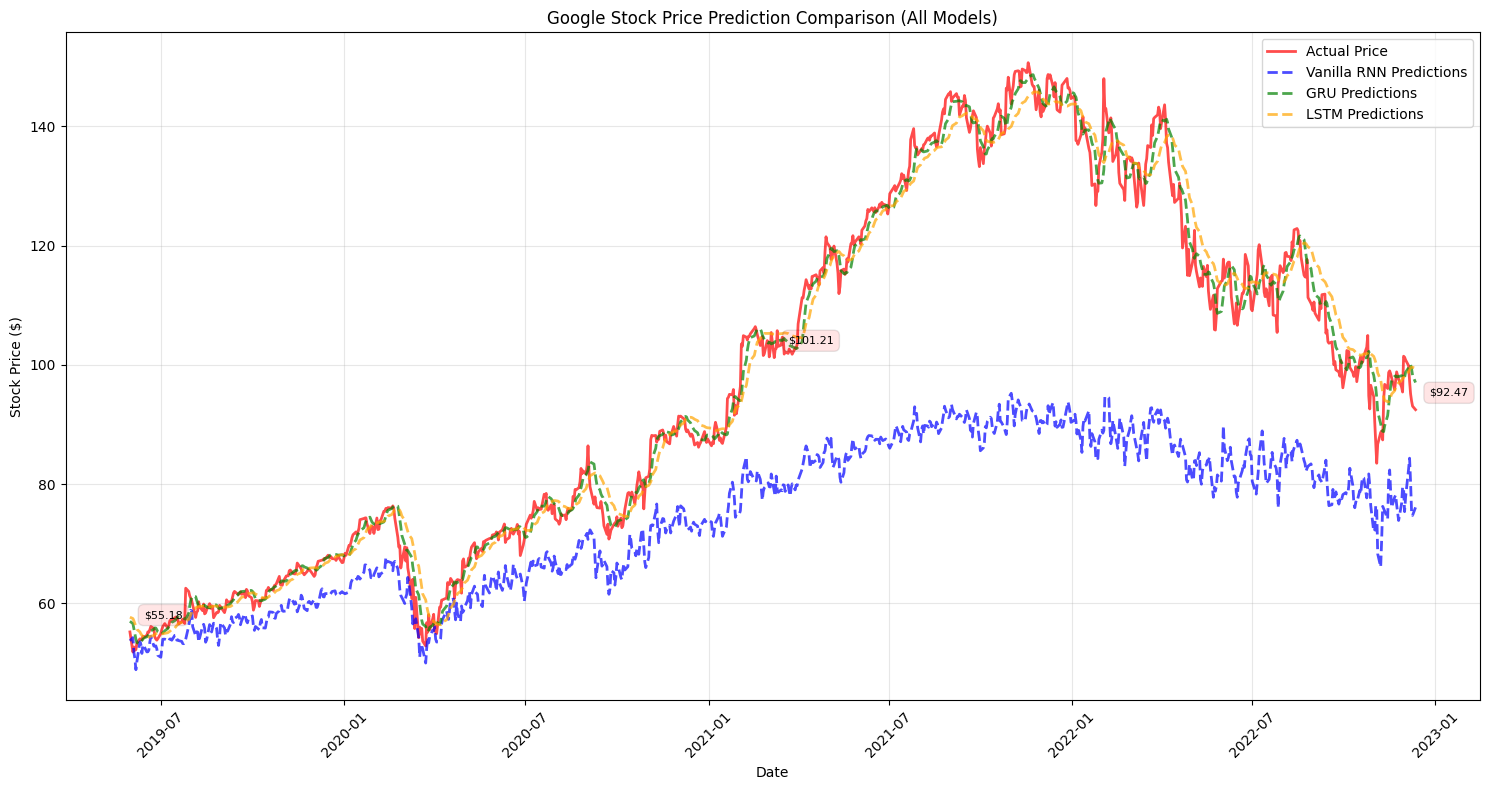

In [145]:
y_pred_dict = {
    'Vanilla RNN': y_pred_vanilla,
    'GRU': y_pred_gru,
    'LSTM': y_pred_lstm
}
plot_combined_predictions_detailed(y_test_dates, y_test_actual, y_pred_dict)
plt.show()

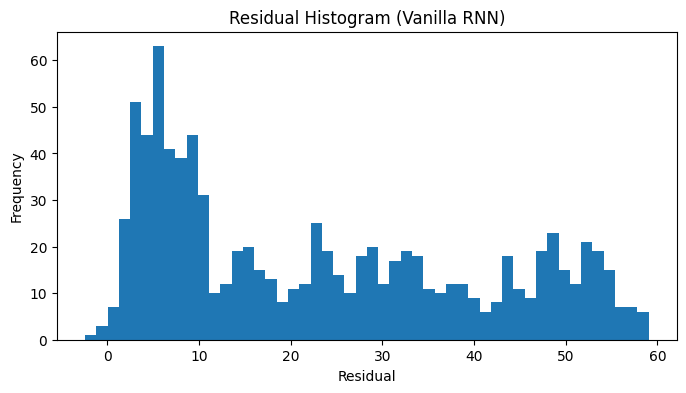

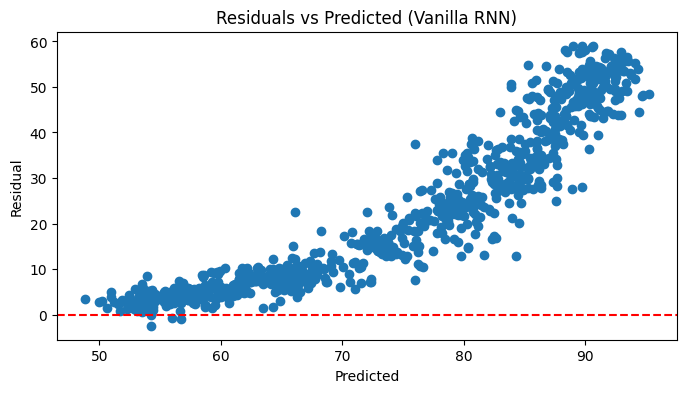

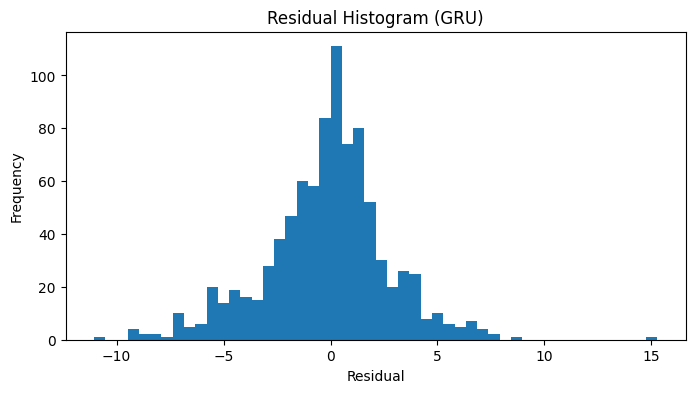

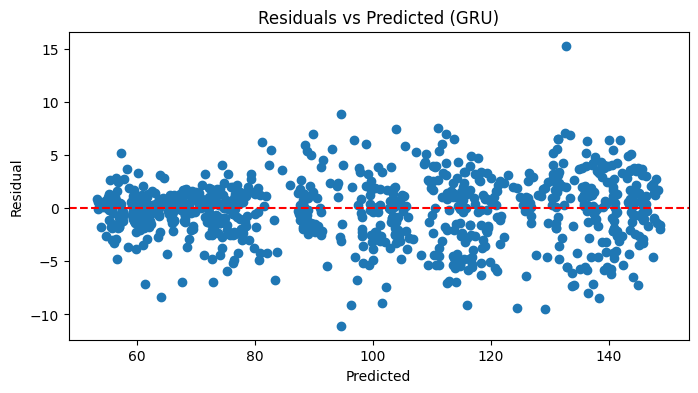

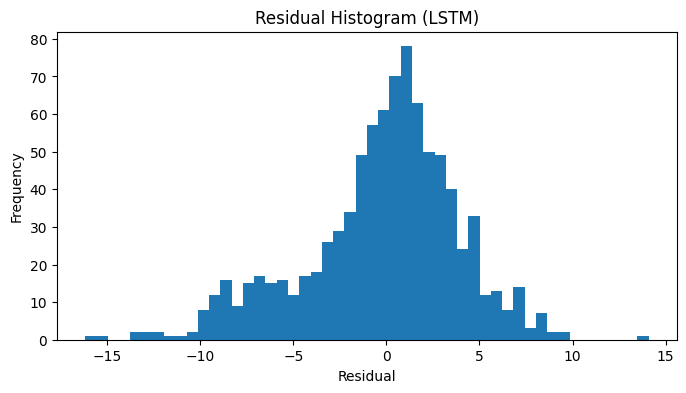

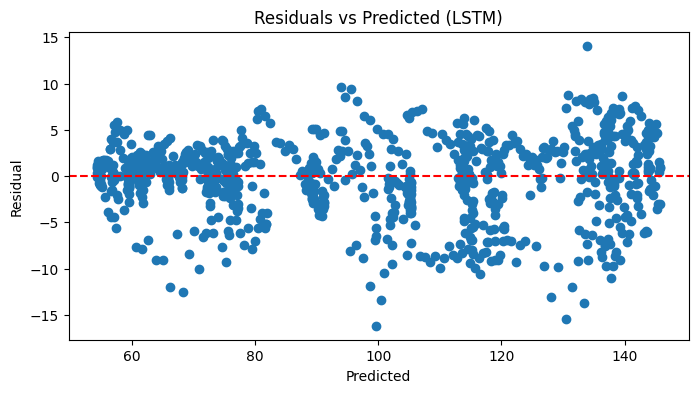

In [146]:
def plot_residuals(y_test_dates, y_test_actual, y_pred, model_name):
    residuals = y_test_actual - y_pred
    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=50)
    plt.title(f'Residual Histogram ({model_name})')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred, residuals)
    plt.title(f'Residuals vs Predicted ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

plot_residuals(y_test_dates, y_test_actual, y_pred_vanilla, 'Vanilla RNN')
plot_residuals(y_test_dates, y_test_actual, y_pred_gru, 'GRU')
plot_residuals(y_test_dates, y_test_actual, y_pred_lstm, 'LSTM')

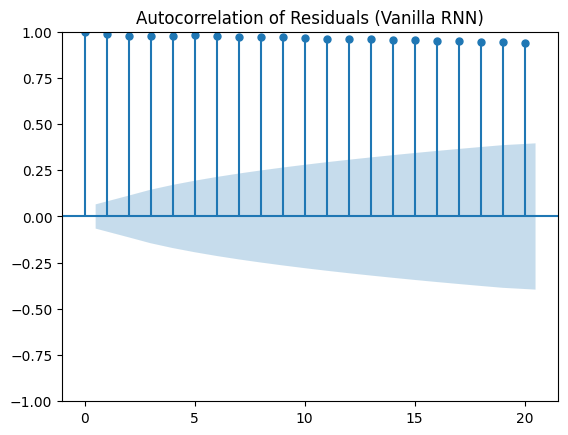

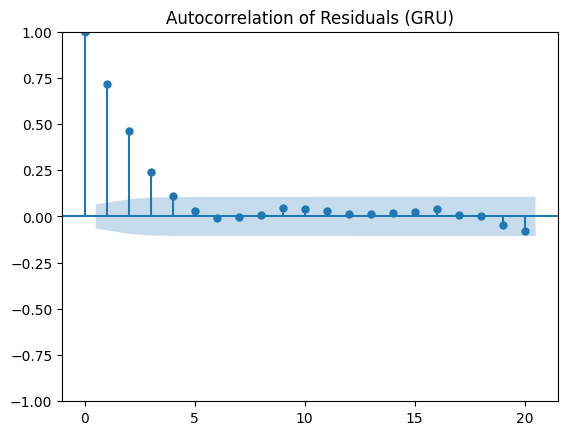

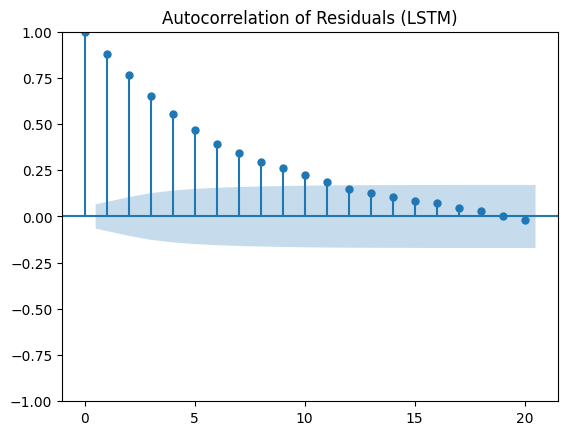

In [147]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acf_residuals(y_test_actual, y_pred, model_name):
    residuals = y_test_actual - y_pred
    plot_acf(residuals, lags=20)
    plt.title(f'Autocorrelation of Residuals ({model_name})')
    plt.show()

plot_acf_residuals(y_test_actual, y_pred_vanilla, 'Vanilla RNN')
plot_acf_residuals(y_test_actual, y_pred_gru, 'GRU')
plot_acf_residuals(y_test_actual, y_pred_lstm, 'LSTM')
